In [1]:
import pandas as pd
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
from umap import UMAP

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

import numpy as np
from hdbscan import HDBSCAN

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/marta/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/home/marta/miniconda3/envs/final_project/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/marta/miniconda3/envs/final_project/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWar

# 0. Importing CSV

In [2]:
streaming_platforms = pd.read_csv("STREAMING_PLATFORMS.csv")

In [3]:
streaming_platforms = streaming_platforms.drop(["Unnamed: 0"], axis = 1)

In [4]:
streaming_platforms.head()

,Streaming_platform,Title,IMDb_id,First Review
0,HBO,Game of Thrones,944947,Let's say you're reading these reviews and hav...
1,HBO,Westworld,475784,"As many sci-fi fans will know, the show 'Westw..."
2,HBO,Silicon Valley,2575988,I have been a member of IMDb for many many yea...
3,HBO,Barry,5348176,I agree with everything good said about this b...
4,HBO,The Sopranos,141842,The Sopranos is arguably the greatest show in ...


In [5]:
reviews = streaming_platforms["First Review"]

In [6]:
reviews_list = list(reviews)

# Sentimental Analyzer

In [7]:
list_of_results = []
    
for i in range(len(reviews_list)):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    scores = sentiment_analyzer.polarity_scores(reviews_list[i])
        
    list_of_results.append(scores)

In [8]:
list_of_results

[{'neg': 0.122, 'neu': 0.667, 'pos': 0.211, 'compound': 0.9862},
 {'neg': 0.097, 'neu': 0.737, 'pos': 0.167, 'compound': 0.9962},
 {'neg': 0.015, 'neu': 0.799, 'pos': 0.186, 'compound': 0.9789},
 {'neg': 0.103, 'neu': 0.679, 'pos': 0.218, 'compound': 0.8658},
 {'neg': 0.086, 'neu': 0.674, 'pos': 0.239, 'compound': 0.9933},
 {'neg': 0.095, 'neu': 0.658, 'pos': 0.247, 'compound': 0.998},
 {'neg': 0.058, 'neu': 0.754, 'pos': 0.188, 'compound': 0.9763},
 {'neg': 0.09, 'neu': 0.799, 'pos': 0.111, 'compound': 0.9639},
 {'neg': 0.018, 'neu': 0.82, 'pos': 0.162, 'compound': 0.9937},
 {'neg': 0.055, 'neu': 0.626, 'pos': 0.318, 'compound': 0.9941},
 {'neg': 0.072, 'neu': 0.653, 'pos': 0.275, 'compound': 0.9803},
 {'neg': 0.088, 'neu': 0.719, 'pos': 0.193, 'compound': 0.996},
 {'neg': 0.045, 'neu': 0.765, 'pos': 0.19, 'compound': 0.9971},
 {'neg': 0.037, 'neu': 0.643, 'pos': 0.319, 'compound': 0.9977},
 {'neg': 0.016, 'neu': 0.773, 'pos': 0.211, 'compound': 0.9978},
 {'neg': 0.01, 'neu': 0.806, '

plot histogram from -1 to 1 with compound

In [9]:
type(list_of_results)

list

In [10]:
sentiment_analyzer = pd.DataFrame.from_dict(list_of_results)

In [11]:
sentiment_analyzer.head()

,neg,neu,pos,compound
0,0.122,0.667,0.211,0.9862
1,0.097,0.737,0.167,0.9962
2,0.015,0.799,0.186,0.9789
3,0.103,0.679,0.218,0.8658
4,0.086,0.674,0.239,0.9933


In [12]:
sentiment_analyzer.columns

Index(['neg', 'neu', 'pos', 'compound'], dtype='object')

In [13]:
sentiment_analyzer = sentiment_analyzer.rename(columns={"compound": "Compound", "neg": "Negative", "neu": "Neutral", "pos": "Positive"})

# Concat both DataFrames

In [14]:
streaming_platforms = pd.concat([streaming_platforms, sentiment_analyzer], axis=1, join='inner')

In [15]:
streaming_platforms.head()

,Streaming_platform,Title,IMDb_id,First Review,Negative,Neutral,Positive,Compound
0,HBO,Game of Thrones,944947,Let's say you're reading these reviews and hav...,0.122,0.667,0.211,0.9862
1,HBO,Westworld,475784,"As many sci-fi fans will know, the show 'Westw...",0.097,0.737,0.167,0.9962
2,HBO,Silicon Valley,2575988,I have been a member of IMDb for many many yea...,0.015,0.799,0.186,0.9789
3,HBO,Barry,5348176,I agree with everything good said about this b...,0.103,0.679,0.218,0.8658
4,HBO,The Sopranos,141842,The Sopranos is arguably the greatest show in ...,0.086,0.674,0.239,0.9933


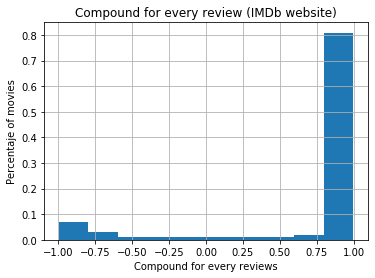

In [16]:
streaming_platforms.hist(column='Compound', weights=np.ones(len(streaming_platforms["Compound"])) / len(streaming_platforms["Compound"]))
plt.xlabel('Compound for every reviews')
plt.ylabel('Percentaje of movies') # y en porcentaje #bins 0.25
plt.title(r'Compound for every review (IMDb website)')
plt.subplots_adjust(left=0.15)

# de las mejores puntuaciones, análisis tfidf plotear en 2d umap #075-1
# hipótesis: 
plt.show()

# Best negative reviews

In [58]:
streaming_platforms.nsmallest(20, ['Compound']).head()

,Streaming_platform,Title,IMDb_id,First Review,Negative,Neutral,Positive,Compound
99,HBO,The Pacific,374463,I'm guessing most of us watched 'The Pacific' ...,0.193,0.674,0.133,-0.9975
156,Netflix,Haters Back Off,5467814,Meant to wait longer before writing this revie...,0.250,0.658,0.093,-0.9968
157,Netflix,Degrassi: Next Class,5320160,For over a decade I have watched Degrassi: Nex...,0.139,0.778,0.083,-0.9947
111,HBO,Witness,2475150,There was a lot of conjecture and innuendo in ...,0.210,0.709,0.082,-0.9775
127,Netflix,Marvel's Jessica Jones,2357547,"This review pains me to write, because I genui...",0.202,0.681,0.118,-0.9702


# An example of a negative review

In [18]:
streaming_platforms["First Review"][137]

"I can honestly say I've never seen anything quite like Marcella. Unfortunately I don't mean that it in a good way. \nThe first season was entertaining if a little frustrating due to having plot points hanging in the air, but I could accept that as it was obvious those plot points would be picked up in season two. \nIt was (note - was) a fairly standard police drama - gritty setting, messed up detective etc. Sure it was a bit silly and far fetched in places but it remained fairly grounded.\nThen came the second season, and wow I don't know what happened in the writer's room, but someone, somewhere lost the plot.\nCharacter after character is introduced to the point where there were so many stories going on that it became hard to keep track of everything. But don't worry I said to myself, at some point all of these stories will come together into an epic finale. And yet no they didn't, many were left unresolved, characters that had big parts for multiple episodes (if not most of the sea

In [19]:
streaming_platforms.to_csv('STREAMING_SENTIMENT_ANALYZER.csv')

# Now we are going to study positive reviews specifically...

In [20]:
streaming_platforms_positive = streaming_platforms.loc[streaming_platforms['Compound'] >= 0.75]

In [21]:
streaming_platforms_positive.head()

,Streaming_platform,Title,IMDb_id,First Review,Negative,Neutral,Positive,Compound
0,HBO,Game of Thrones,944947,Let's say you're reading these reviews and hav...,0.122,0.667,0.211,0.9862
1,HBO,Westworld,475784,"As many sci-fi fans will know, the show 'Westw...",0.097,0.737,0.167,0.9962
2,HBO,Silicon Valley,2575988,I have been a member of IMDb for many many yea...,0.015,0.799,0.186,0.9789
3,HBO,Barry,5348176,I agree with everything good said about this b...,0.103,0.679,0.218,0.8658
4,HBO,The Sopranos,141842,The Sopranos is arguably the greatest show in ...,0.086,0.674,0.239,0.9933


# Reviews cleaning

In [22]:
nlp = spacy.load('en')
parser = English()

In [23]:
def spacy_tokenizer(sentence):

    tokens = parser(sentence)
    
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [24]:
spacy_tokenizer(streaming_platforms_positive["First Review"][1])[:15]

['sci',
 'fi',
 'fan',
 'know',
 'westworld',
 'base',
 'feature',
 'film',
 'write',
 'direct',
 'michael',
 'crichton',
 'premise',
 'basically',
 'future']

# TD-IDF

In [25]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.10, tokenizer=spacy_tokenizer, ngram_range=(1,2))

tfidf_matrix = tfidf_vectorizer.fit_transform(streaming_platforms_positive["First Review"])

tfidf_matrix.shape

(132, 114)

In [26]:
terms = tfidf_vectorizer.get_feature_names()

terms[:30]

['act',
 'actor',
 'add',
 'amaze',
 'away',
 'bad',
 'believe',
 'big',
 'bite',
 'bring',
 'cast',
 'character',
 'close',
 'come',
 'comedy',
 'course',
 'dark',
 'day',
 'doe',
 'drama',
 'end',
 'enjoy',
 'episode',
 'especially',
 'excellent',
 'expect',
 'experience',
 'fact',
 'family',
 'fan']

In [27]:
dist = 1 - cosine_similarity(tfidf_matrix)

dist.shape

(132, 132)

# Clustering 

# UMAP

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    umap = UMAP(random_state=42)
    embedding = umap.fit_transform(dist)

embedding[:5]

array([[-6.8534856,  6.0585203],
       [-5.104974 ,  3.5356026],
       [-4.779498 ,  5.6587315],
       [-2.5394847,  3.446553 ],
       [-4.6553392,  6.8257313]], dtype=float32)

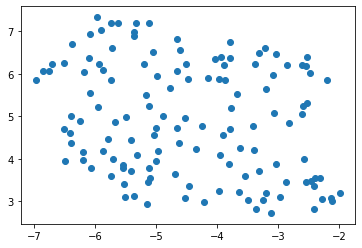

In [29]:
plt.scatter(embedding[:,0], embedding[:,1]);

# HDBSCAN

In [30]:
hdbscan = HDBSCAN(min_cluster_size=8)

clustering = hdbscan.fit_predict(embedding)

np.unique(clustering)

array([-1,  0,  1,  2])

# Three clusters !

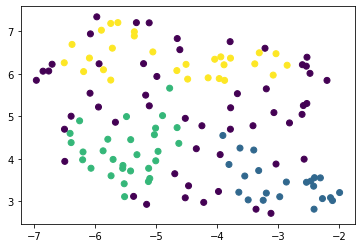

In [31]:
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);

In [32]:
def get_titles_from_cluster(cluster):
    return pd.Series(streaming_platforms_positive["Title"])[clustering==cluster]

# Titles from the first cluster (Fun)

In [33]:
titles_cluster = get_titles_from_cluster(0)
titles_cluster

3                                           Barry
9                                         Ballers
13                           Curb Your Enthusiasm
27                                Vice Principals
43                                        Animals
44                           The Kids in the Hall
49                            Summer Heights High
54                                   Hello Ladies
57                         The Ricky Gervais Show
60                      How to Make It in America
69                                    Family Tree
73                             Little Britain USA
76                          Funny or Die Presents
93                           Dane Cook's Tourgasm
103                          HBO Comedy Half-Hour
115                                   Tenacious D
123                Sinatra: All or Nothing at All
126                            Santa Clarita Diet
131                                          Love
141                                     The Ranch


# Titles from the second cluster (Fan)

In [34]:
titles_cluster = get_titles_from_cluster(1)
titles_cluster

1                        Westworld
2                   Silicon Valley
5                   True Detective
7                       True Blood
11                        Deadwood
12                   The Leftovers
24                    The Newsroom
33                          Extras
47                    Togetherness
51     Mr. Show with Bob and David
56                       The Brink
62                    Intelligence
64                       Doll & Em
77              Project Greenlight
87                   Magnifica '70
90               Neverending Story
100                     John Adams
102                      Five Days
106                 Temple Grandin
107            You Don't Know Jack
109              Angels in America
119               Olive Kitteridge
128                Stranger Things
129                 Altered Carbon
139           Arrested Development
140                         Sense8
145                       G.L.O.W.
152                     Marco Polo
161                C

# Titles from the third cluster (cinemagoer)

In [35]:
titles_cluster = get_titles_from_cluster(2)
titles_cluster

6                                             The Wire
10                                    Boardwalk Empire
22                                             Divorce
23                             High Maintenance (2016)
26                                      The Young Pope
30                                           Carnivale
32                                                Hung
34                                             Camelot
41                                        Fraggle Rock
48                                        The Comeback
50                            The Adventures of Tintin
53                                         Enlightened
58                         Ja'mie: Private School Girl
65                        Jim Henson's the Storyteller
68                  The No. 1 Ladies' Detective Agency
71                                         Lucky Louie
79                                            Crashbox
82                                           Sr. Avila
86        

In [36]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

In [37]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

In [38]:
get_df_from_cluster(0).T.head()

,3,9,13,25,39,40,43,48,51,53,...,67,82,89,98,103,106,109,116,127,130
act,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.069166,0.163076,0.0,0.0,0.234883,0.0,0.0,0.0,0.198643,0.000000
actor,0.000000,0.150530,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.205465
add,0.493829,0.000000,0.0,0.0,0.0,0.0,0.224666,0.197517,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.131193
amaze,0.000000,0.199491,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
away,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.205686,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


# Reviews from the third cluster (Cinemagoer)

In [39]:
streaming_platforms_positive["First Review"][6]

"Along with TV-shows like 'Oz', 'Deadwood', 'The Sopranos' and 'Six Feet Under', David Simon's 'The Wire' was part of a revolution - qualitywise - in television. Although it is very entertaining, this isn't just entertainment; this is art, pure and simple - and the concept of this show was groundbreaking. On the surface, one might think this is a show about crime, but really, 'The Wire' is about the life and soul of a whole city. Every aspect of the city of Baltimore gets its share of screen time, and the way this is done - the writing, the direction, the amazing performances by the terrific cast; the music, the camera work, the realism... I could go on and on - is just outstanding. On par with 'Generation Kill' (no wonder, since the same creative team was behind both), this is as good as television gets.Favorite films: http://www.IMDb.com/list/mkjOKvqlSBs/Lesser-known Masterpieces: http://www.imdb.com/list/ls070242495/Favorite Low-Budget and B-Movies: http://www.imdb.com/list/ls054808

In [40]:
streaming_platforms_positive["First Review"][10]

'This show is loaded with excellent acting and writing!!!!! It\'s worth watching every minute and shot. Steve Buscemi definitely deserves an Emmy for his portrayal of "Nucky." I haven\'t enjoyed a show from HBO this much since "Deadwood." The characters are well layered and the dialogue is fantastic. The supporting cast is immensely talented and the scenery is simply gorgeous. Michael Pitt is a pleasure to watch in his, complex role of the war hero gone bad. I hope this show lasts a lot longer than "Deadwood" did and makes household names out of its cast. I\'ll keep my HBO subscription forever if more shows like these are on the horizon.'

In [41]:
streaming_platforms_positive["First Review"][26]

"I guess I should start with what I don't like about this show - the dialogue is somewhat unnatural. There's no umming or erring at all, conversations are as rapid and resolute as in an American crime procedural, which is slightly weird most of the time but especially disturbing when coming from actors who aren't speaking in their first language, who happen to make up the vast majority of actors on this show. That's it as far as flaws though, and I won't even deduct any points for this one flaw because there's a positive aspect to it, to the point that I can't even be 100% sure it wasn't intended - it adds to the feeling of surrealism that permeates every scene in this unique and wonderful creation. And when I say wonderful I mean it literally - this show is full of wonders at every corner. It keeps you constantly surprised, on edge, unsure of what on earth could possibly come next. The plot, the writing, the cinematography, the acting, the music, oh the music! The choice of music, the

# Most common words on reviews from the third cluster (Cinemagoer)

In [42]:
top_words_cluster = get_df_from_cluster(2).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster

episode       3.868107
tv            3.680526
watch         3.580681
series        3.558197
hbo           3.139232
                ...   
need          0.169138
right         0.118776
close         0.000000
experience    0.000000
probably      0.000000
Length: 114, dtype: float64

In [43]:
keywords_cluster2 = top_words_cluster.keys()
keywords_cluster2

Index(['episode', 'tv', 'watch', 'series', 'hbo', 'great', 'love', 'good',
       'year', 'season',
       ...
       'comedy', 'main', 'role', 'line', 'young', 'need', 'right', 'close',
       'experience', 'probably'],
      dtype='object', length=114)

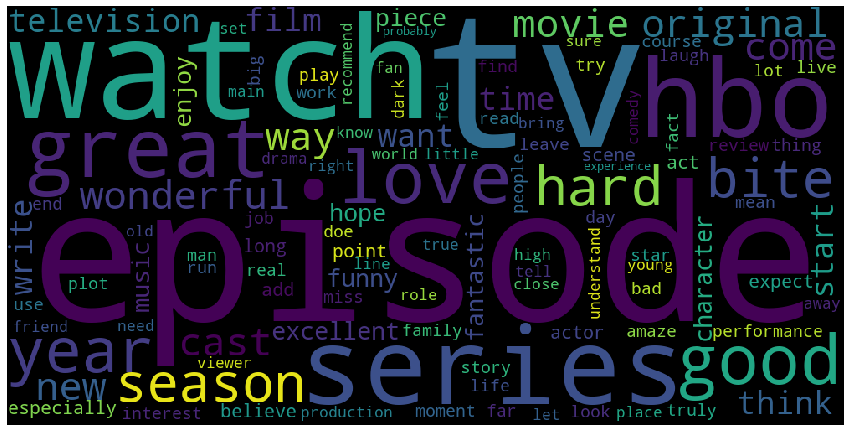

In [44]:
unique_string=(" ").join(keywords_cluster2)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("top_words_cluster_2"+".png", bbox_inches='tight')
plt.show()
plt.close()

# Reviews from the second cluster (Fan)

In [45]:
streaming_platforms_positive["First Review"][1]

'As many sci-fi fans will know, the show \'Westworld\' is based on the 1973 feature film of the same name (written and directed by Michael Crichton), and the premise is basically the same as it was then: In a future where technological possibilities are seemingly endless, a highly sophisticated theme park offers rich clients the chance to visit the long gone era of the Old West (Crichton later explored a variation of that theme in a certain well known novel - which was then adapted by a certain Mr. Spielberg - albeit with slightly different creatures than cowboys populating a slightly more "jurassic" environment).The show does a great job pulling the viewer immediately into \n Westworld. Within 10 minutes of the first episode, the basic rules of \n the theme park are established: paying guests called "newcomers" get to \n interact with androids called "hosts" (which to the naked eye are \n indiscernible from the guests) in a world dressed up like the Old West \n - and in this world, th

In [56]:
streaming_platforms_positive["First Review"][11]

'If you want to experience the – real – old west first hand, look no further; you\'ll find it in \'Deadwood\'. There has never been a show or a film that came as close to showing what life must have been like in those lawless young towns that got built nearly over night wherever gold was found. A magnet for all kind of fortune seekers (gold diggers, whores, outlaws – but also settlers who were just hoping to build a better life), the town of Deadwood was notorious even by the standards of the time. In the show, this "cesspool of vice" is brought back to life with great attention to historical detail. You\'ll find no romanticised view of pioneers who lived and died by "the code of honour", but real people whose moral standards are – in most cases – murky at best. And the world they inhabit is a rough, dirty, violent place where only the fiercest – and the most cunning – survive. As far as the historical characters depicted in the show are concerned, the writers naturally had to take som

In [57]:
streaming_platforms_positive["First Review"][109]

"It seems to me that to be able to experience the full depth of this production, you need to meet a few requirements. First, you need to know that this is a PLAY. Like in any play, texts are delivered that you will not easily hear in everyday life (nobody makes up 'Antebellum Insufficiently Developed Sexorgans' as an alternative interpretation of AIDS during a split second in mid-conversation). Shakespeare isn't realistic in that way, Oscar Wilde isn't, Ibsen isn't, and nor is Tony Kushner. All of them are however extremely realistic in that they highlight essential aspects of the human condition in ways no other medium can achieve. Second, you need an ability to look beyond the surface. Reading reviews of AinA I'm stunned at how simplistically literal some people take it (maybe that explains why you've got Bush for president over there?). This play isn't about gays, it isn't about AIDS, it isn't about Jews and it isn't about Mormons. Its theme is the necessity for people to change, th

# Most common words on reviews from the third cluster (Fan)

In [48]:
top_words_cluster = get_df_from_cluster(1).T.sum(axis=1).sort_values(ascending=False)
print(top_words_cluster)

film         5.068929
play         4.156612
character    3.987137
like         3.360701
good         3.344795
               ...   
let          0.434462
wonderful    0.434209
probably     0.394429
music        0.379332
add          0.323312
Length: 114, dtype: float64


In [49]:
keywords_cluster1 = top_words_cluster.keys()
keywords_cluster1

Index(['film', 'play', 'character', 'like', 'good', 'great', 'movie', 'life',
       'cast', 'people',
       ...
       'old', 'run', 'bad', 'start', 'fantastic', 'let', 'wonderful',
       'probably', 'music', 'add'],
      dtype='object', length=114)

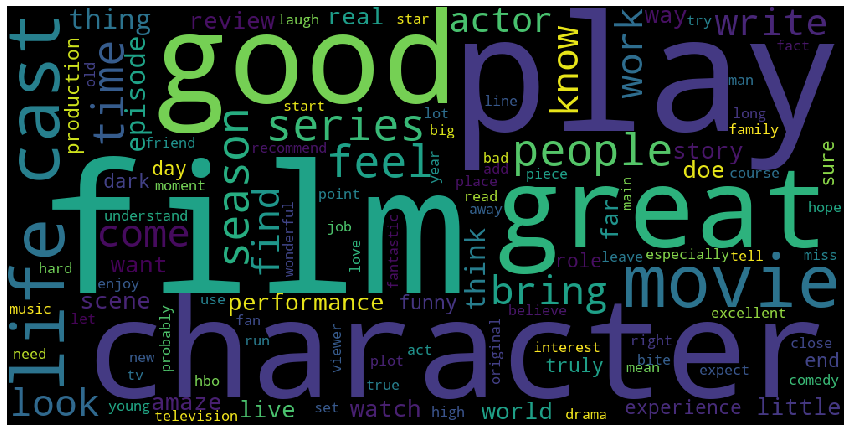

In [50]:
unique_string=(" ").join(keywords_cluster1)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("top_words_cluster_1"+".png", bbox_inches='tight')
plt.show()
plt.close()

# Reviews from the first cluster (Fun)

In [51]:
streaming_platforms_positive["First Review"][126]

"I saw this show advertised and thought it may be OK to fill a gap if there was nothing much else on to watch.The first episode was good, so I watched the second, then the third, and couldn't stop watching it as each episode got better and better as the characters developed.Each and every performance in this comedy is brilliant, from the most minor of supporting roles to the lead cast.I really didn't have high expectations, but this comedy is HILARIOUS"

In [52]:
streaming_platforms_positive["First Review"][76]

"Funny or Die Presents is the new comedy series from HBO, which would basically be the same type of content you would see on Funny or Die. Since it doesn't allow you to rate the segments on TV, it's a mixed bag of some funny sketches, as well as some that are just plain awful.Will Ferrell launched his popular comedy video website in 2007. In that short time, it's already been producing some of the funniest videos on the internet, that is when it's funny. That is only half of Funny or Die.There is a certain process to Funny or Die. After watching the video, viewers have the option of giving it a good rating (Funny) or a bad rating (Die) and there is a meter displaying the percentage of people who rated it Funny. It's just like Rotten Tomatoes, but with comedy sketches. The website of course has more Die than Funny, but you don't have to watch them.I really like how the show is set up like a half-hour television network with 2-5 minute programs, like SCTV has done in the past. The show h

# Most common words on reviews from the first cluster (Fun)

In [53]:
top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster

comedy       6.651989
funny        4.496672
like         4.257421
good         2.151403
people       1.960209
               ...   
piece        0.000000
wonderful    0.000000
close        0.000000
plot         0.000000
start        0.000000
Length: 114, dtype: float64

In [54]:
keywords_cluster0 = top_words_cluster.keys()
keywords_cluster0

Index(['comedy', 'funny', 'like', 'good', 'people', 'laugh', 'watch',
       'character', 'love', 'little',
       ...
       'scene', 'main', 'music', 'bring', 'production', 'piece', 'wonderful',
       'close', 'plot', 'start'],
      dtype='object', length=114)

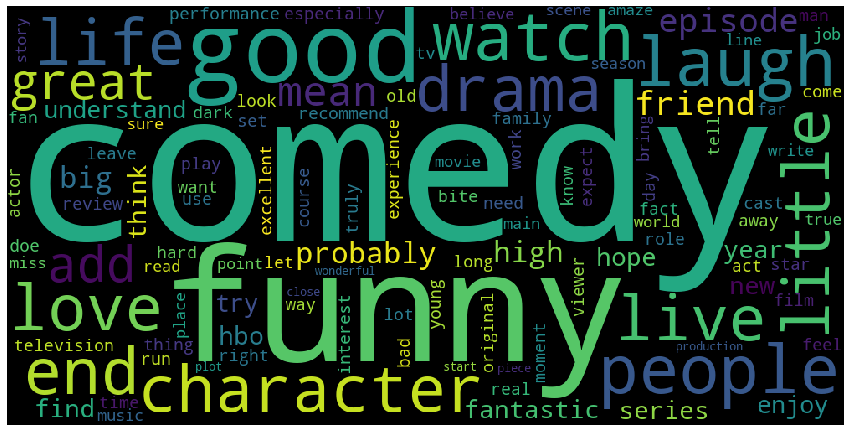

In [55]:
unique_string=(" ").join(keywords_cluster0)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("top_words_cluster_0"+".png", bbox_inches='tight')
plt.show()
plt.close()